In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from unityagents import UnityEnvironment
from torch.utils.data import TensorDataset, DataLoader
import os

# Actor Network
class Actor(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_size=256):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        self.mu = nn.Linear(hidden_size, act_dim)
        self.log_std = nn.Parameter(torch.zeros(act_dim))
        
    def forward(self, x):
        x = self.net(x)
        mu = torch.tanh(self.mu(x))
        std = torch.exp(self.log_std).expand_as(mu)
        return mu, std

# Centralized Critic Network
class Critic(nn.Module):
    def __init__(self, state_dim, hidden_size=256):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
    def forward(self, x):
        return self.net(x)

# MAPPO Agent
class MAPPO:
    def __init__(self, obs_dim, act_dim, state_dim, num_agents,
                 gamma=0.99, clip_param=0.2, ppo_epochs=10, lr=3e-4,
                 batch_size=64, gae_lambda=0.95, entropy_coef=0.01):
        
        self.actors = nn.ModuleList([Actor(obs_dim, act_dim) for _ in range(num_agents)])
        self.critic = Critic(state_dim)
        self.optimizer = optim.Adam([
            {'params': self.actors.parameters()},
            {'params': self.critic.parameters()}
        ], lr=lr)
        
        self.gamma = gamma
        self.clip_param = clip_param
        self.ppo_epochs = ppo_epochs
        self.batch_size = batch_size
        self.gae_lambda = gae_lambda
        self.entropy_coef = entropy_coef
        self.num_agents = num_agents
        self.act_dim = act_dim
        self.lr = lr
        # Add model directory parameter
        self.model_dir = "models/"
        os.makedirs(self.model_dir, exist_ok=True)

    def act(self, obs, agent_idx):
        with torch.no_grad():
            obs_tensor = torch.FloatTensor(obs)
            mu, std = self.actors[agent_idx](obs_tensor)
            dist = torch.distributions.Normal(mu, std)
            action = dist.sample()
            action = np.clip(action, -1., 1.)
            log_prob = dist.log_prob(action).sum(-1)
        return action.numpy(), log_prob.numpy()

    def update(self, buffer, curr_episode, max_episode):
        # Convert buffer to tensors
        states = torch.FloatTensor(np.array(buffer.global_states))
        next_states = torch.FloatTensor(np.array(buffer.next_global_states))
        individual_obs = torch.FloatTensor(np.array(buffer.individual_obs))
        actions = torch.FloatTensor(np.array(buffer.actions))
        rewards = torch.FloatTensor(np.array(buffer.rewards))
        dones = torch.FloatTensor(np.array(buffer.dones))
        old_log_probs = torch.FloatTensor(np.array(buffer.log_probs))
        agent_indices = torch.LongTensor(np.array(buffer.agent_indices))

        # Calculate advantages using GAE
        with torch.no_grad():
            values = self.critic(states).squeeze()
            next_values = self.critic(next_states).squeeze()
            
            advantages = torch.zeros_like(rewards)
            last_advantage = 0
            for t in reversed(range(len(rewards))):
                mask = 1.0 - dones[t]
                delta = rewards[t] + self.gamma * next_values[t] * mask - values[t]
                advantages[t] = delta + self.gamma * self.gae_lambda * mask * last_advantage
                last_advantage = advantages[t]
            returns = advantages + values

        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # Create dataset
        dataset = TensorDataset(individual_obs, actions, old_log_probs, 
                               advantages, returns, states, agent_indices)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        # PPO update
        # the 1st 10k episodes do not decay
        decay_delay = 15000.
        learn_decay_ratio = max(0., curr_episode - decay_delay) / max_episode
        curr_clip_eps = self.clip_param #max(0.1, self.clip_param * (1. - learn_decay_ratio))
        curr_entropy_coef = self.entropy_coef # max(0.01, self.entropy_coef * (1. - learn_decay_ratio))
        curr_epochs = int(max(3, int(self.ppo_epochs * (1. - learn_decay_ratio))))
        final_lr = 1e-5  # More stability later
        self.optimizer.param_groups[0]["lr"] = max(final_lr, self.lr * (1. - learn_decay_ratio))
        for _ in range(curr_epochs):
            for batch in dataloader:
                ind_obs_b, actions_b, old_log_probs_b, adv_b, ret_b, states_b, agent_idx_b = batch
                
                policy_losses = []
                entropy_losses = []
                
                # Update each agent's policy
                for agent_id in range(self.num_agents):
                    mask = agent_idx_b == agent_id
                    if mask.sum() == 0:
                        continue
                    
                    # Agent-specific data
                    agent_obs = ind_obs_b[mask]
                    agent_actions = actions_b[mask]
                    agent_old_log_probs = old_log_probs_b[mask]
                    agent_adv = adv_b[mask]
                    
                    # Calculate new policy
                    mu, std = self.actors[agent_id](agent_obs)
                    dist = torch.distributions.Normal(mu, std)
                    new_log_probs = dist.log_prob(agent_actions).sum(-1)
                    entropy = dist.entropy().mean()
                    
                    # Policy loss
                    ratio = (new_log_probs - agent_old_log_probs).exp()
                    surr1 = ratio * agent_adv
                    surr2 = torch.clamp(ratio, 1.0 - curr_clip_eps, 
                                      1.0 + curr_clip_eps) * agent_adv
                    policy_loss = -torch.min(surr1, surr2).mean()
                    
                    policy_losses.append(policy_loss)
                    entropy_losses.append(entropy)

                # Combine losses
                policy_loss = torch.stack(policy_losses).mean() if policy_losses else 0.0
                entropy_loss = torch.stack(entropy_losses).mean() if entropy_losses else 0.0
                
                # Value loss
                values_pred = self.critic(states_b).squeeze()
                value_loss = F.mse_loss(values_pred, ret_b)
                
                # Total loss
                total_loss = policy_loss + value_loss - curr_entropy_coef * entropy_loss
                
                # Optimize
                self.optimizer.zero_grad()
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.actors.parameters(), 0.5)
                torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 0.5)
                self.optimizer.step()
        
        buffer.clear()

    def save(self, episode=None, save_optimizer=True):
        """Save model checkpoints"""
        checkpoint = {
            # Save all actors' state dicts
            'actors': [actor.state_dict() for actor in self.actors],
            'critic': self.critic.state_dict(),
            'optimizer': self.optimizer.state_dict() if save_optimizer else None,
            'num_agents': self.num_agents,  # Critical for verification
            'episode': episode
        }
        
        filename = f"mappo_checkpoint"
        if episode is not None:
            filename += f"_ep{episode}"
        filename += ".pth"
        
        torch.save(checkpoint, os.path.join(self.model_dir, filename))
        print(f"Saved checkpoint to {filename}")

    def load(self, path, load_optimizer=True):
        """Load model checkpoints"""
        if not os.path.exists(path):
            raise FileNotFoundError(f"No checkpoint found at {path}")
            
        checkpoint = torch.load(path)

        # Verify compatibility
        if checkpoint['num_agents'] != self.num_agents:
            raise ValueError(f"Checkpoint has {checkpoint['num_agents']} agents, "
                             f"but current setup has {self.num_agents}")
        
        # Load each actor individually
        for i, actor in enumerate(self.actors):
            actor.load_state_dict(checkpoint['actors'][i])
        
        # Load optimizer if requested
        if load_optimizer and checkpoint['optimizer'] is not None:
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            
        print(f"Loaded checkpoint from {path}")
        return checkpoint.get('episode', 0)

# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self):
        self.global_states = []
        self.individual_obs = []
        self.actions = []
        self.rewards = []
        self.next_global_states = []
        self.dones = []
        self.log_probs = []
        self.agent_indices = []
        
    def add(self, global_state, individual_obs, action, reward, 
            next_global_state, done, log_prob, agent_idx):
        self.global_states.append(global_state)
        self.individual_obs.append(individual_obs)
        self.actions.append(action)
        self.rewards.append(reward)
        self.next_global_states.append(next_global_state)
        self.dones.append(done)
        self.log_probs.append(log_prob)
        self.agent_indices.append(agent_idx)
        
    def clear(self):
        self.global_states = []
        self.individual_obs = []
        self.actions = []
        self.rewards = []
        self.next_global_states = []
        self.dones = []
        self.log_probs = []
        self.agent_indices = []


In [2]:

# Training Loop
# Declare agent
import sys
# Add the subfolder to sys.path
sys.path.append('./tennis')
# env = UnityEnvironment(file_name="tennis/Tennis.app")
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Environment parameters
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
obs_dim = env_info.vector_observations.shape[1]
print("state size: ", obs_dim)
act_dim = brain.vector_action_space_size
print("action size: ", act_dim)
state_dim = obs_dim * num_agents

# Initialize MAPPO
mappo = MAPPO(obs_dim, act_dim, state_dim, num_agents, gamma=0.99, clip_param=0.2, ppo_epochs=10, lr=1e-4,
                 batch_size=512, gae_lambda=0.9, entropy_coef=0.02)
buffer = ReplayBuffer()


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


state size:  24
action size:  2


Saved checkpoint to mappo_checkpoint_ep0.pth
Episode 20, Current Reward: 0.00, Average Reward (Last 100): 0.01, Reward Var (Last 100): 0.00, Max Reward: 0.10, Min Reward: 0.00, Curr Avg: 0.01, Best Reward: 0.00
Episode 40, Current Reward: 0.00, Average Reward (Last 100): 0.01, Reward Var (Last 100): 0.00, Max Reward: 0.29, Min Reward: 0.00, Curr Avg: 0.01, Best Reward: 0.00
Episode 60, Current Reward: 0.09, Average Reward (Last 100): 0.01, Reward Var (Last 100): 0.00, Max Reward: 0.10, Min Reward: 0.00, Curr Avg: 0.01, Best Reward: 0.00
Episode 80, Current Reward: 0.00, Average Reward (Last 100): 0.01, Reward Var (Last 100): 0.00, Max Reward: 0.10, Min Reward: 0.00, Curr Avg: 0.01, Best Reward: 0.00
Episode 100, Current Reward: 0.00, Average Reward (Last 100): 0.01, Reward Var (Last 100): 0.00, Max Reward: 0.20, Min Reward: 0.00, Curr Avg: 0.01, Best Reward: 0.00
Episode 120, Current Reward: 0.00, Average Reward (Last 100): 0.02, Reward Var (Last 100): 0.00, Max Reward: 0.10, Min Rewar

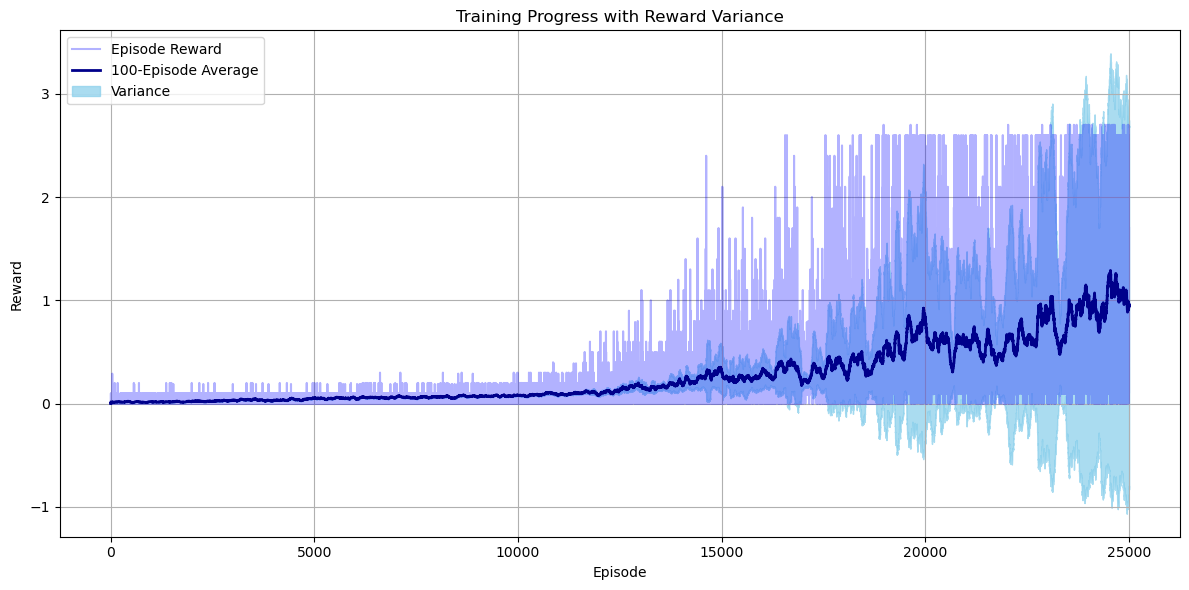

In [3]:
import os
from collections import deque

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Training parameters
max_episodes = 25000
max_steps = 1000
update_freq = 2048
print_interval = 20          # Print stats every 10 episodes
save_interval = 100          # Save model every 100 episodes
solved_threshold = 2.0       # Consider solved when average score > 0.5

# Track rewards
episode_rewards = []
moving_avg = []
moving_var = []  # New variance tracking
best_avg_reward = -np.inf
reward_window = deque(maxlen=100)  # For rolling average

# Create directory for model saves
if not os.path.exists('models'):
    os.makedirs('models')

# Training loop
for episode in range(max_episodes):
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations
    episode_reward= np.zeros(num_agents)

    for step in range(max_steps):
        global_state = states.reshape(-1)
        actions = []
        log_probs = []

        # Get actions from all agents
        for agent_id in range(num_agents):
            action, log_prob = mappo.act(states[agent_id], agent_id)
            actions.append(action)
            log_probs.append(log_prob)

        # Environment step
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done

        # Store experiences
        episode_reward += rewards
        next_global_state = next_states.reshape(-1)

        for agent_id in range(num_agents):
            buffer.add(
                global_state=global_state,
                individual_obs=states[agent_id],
                action=actions[agent_id],
                # reward=sum(rewards),
                reward=rewards[agent_id],
                next_global_state=next_global_state,
                done=dones[agent_id],
                log_prob=log_probs[agent_id],
                agent_idx=agent_id
            )

        states = next_states

        # Update when buffer is full
        if len(buffer.rewards) >= update_freq:
            mappo.update(buffer, episode, max_episodes)

        if np.any(dones):
            break
    
    # Update reward tracking
    episode_rewards.append(max(episode_reward))
    reward_window.append(max(episode_reward))
    current_avg = np.mean(reward_window)
    current_var = np.var(list(reward_window))  # Calculate variance
    moving_avg.append(current_avg)
    moving_var.append(current_var)  # Store variance
    
    # Save best model
    if current_avg > (best_avg_reward + 0.05):
        best_avg_reward = current_avg
        mappo.save(episode=episode)
    
    # Print statistics
    if (episode + 1) % print_interval == 0:
        print(f"Episode {episode + 1}, Current Reward: {max(episode_reward):.2f}, Average Reward (Last 100): {current_avg:.2f}, Reward Var (Last 100): {current_var:.2f}, Max Reward: {np.max(episode_rewards[-print_interval:]):.2f}, Min Reward: {np.min(episode_rewards[-print_interval:]):.2f}")

    # Early stopping if solved
    if current_avg >= solved_threshold:
        print(f"\nEnvironment solved in {episode + 1} episodes!")
        print(f"Average Reward: {current_avg:.2f}")
        break

env.close()

mappo.save(episode=max_episodes)

# Plotting the rewards (add this at the end)
import matplotlib.pyplot as plt
# Modified Plotting Section
plt.figure(figsize=(12, 6))

# Calculate standard deviation from variance for visualization
std_dev = np.sqrt(np.array(moving_var))

# Plot main reward curve and average
plt.plot(episode_rewards, alpha=0.3, color='blue', label='Episode Reward')
plt.plot(moving_avg, linewidth=2, color='darkblue', label='100-Episode Average')

# Plot variance as shaded area around the mean
plt.fill_between(range(len(moving_avg)), 
                 np.array(moving_avg) - np.array(moving_var) * 2.,
                 np.array(moving_avg) + np.array(moving_var) * 2.,
                 color='skyblue', alpha=0.7, label='Variance')

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Progress with Reward Variance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('reward_with_variance.png')
plt.show()

In [2]:
# Test the model

# Training Loop
# Declare agent
import sys
# Add the subfolder to sys.path
sys.path.append('./tennis')
# env = UnityEnvironment(file_name="tennis/Tennis.app")
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Environment parameters
env_info = env.reset(train_mode=False)[brain_name]
num_agents = len(env_info.agents)
obs_dim = env_info.vector_observations.shape[1]
print("state size: ", obs_dim)
act_dim = brain.vector_action_space_size
print("action size: ", act_dim)
state_dim = obs_dim * num_agents

# Initialize MAPPO
mappo = MAPPO(obs_dim, act_dim, state_dim, num_agents, gamma=0.99, clip_param=0.2, ppo_epochs=10, lr=1e-4,
                 batch_size=512, gae_lambda=0.9, entropy_coef=0.02)
# Load from checkpoint
loaded_episode = mappo.load("models/mappo_checkpoint_ep25000.pth", load_optimizer=False)
print(f"Resuming training from episode {loaded_episode}")

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
states = env_info.vector_observations              # get the current state
for _ in range(3000):
    actions = []
    log_probs = []
    for agent_id in range(num_agents):
        action, log_prob = mappo.act(states[agent_id], agent_id)
        actions.append(action)
        log_probs.append(log_prob)
    env_info = env.step(actions)[brain_name]
    states = env_info.vector_observations
env.close()



INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


state size:  24
action size:  2


C:\Users\xiaoy\AppData\Local\Temp\ipykernel_35212\1347071209.py:201: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Loaded checkpoint from models/mappo_checkpoint_ep25000.pth
Resuming training from episode 25000
1
cnt  2 , done:  [False, False]
2
cnt  3 , done:  [False, False]
3
cnt  4 , done:  [False, False]
4
cnt  5 , done:  [False, False]
5
cnt  6 , done:  [False, False]
6
cnt  7 , done:  [False, False]
7
cnt  8 , done:  [False, False]
8
cnt  9 , done:  [False, False]
9
cnt  10 , done:  [False, False]
10
cnt  11 , done:  [False, False]
11
cnt  12 , done:  [False, False]
12
cnt  13 , done:  [False, False]
13
cnt  14 , done:  [False, False]
14
cnt  15 , done:  [False, False]
15
cnt  16 , done:  [False, False]
16
cnt  17 , done:  [False, False]
17
cnt  18 , done:  [False, False]
18
cnt  19 , done:  [False, False]
19
cnt  20 , done:  [False, False]
20
cnt  21 , done:  [False, False]
21
cnt  22 , done:  [False, False]
22
cnt  23 , done:  [False, False]
23
cnt  24 , done:  [False, False]
24
cnt  25 , done:  [False, False]
25
cnt  26 , done:  [False, False]
26
cnt  27 , done:  [False, False]
27
cnt  28 